# Word2Vec CBOW with Negative Sampling

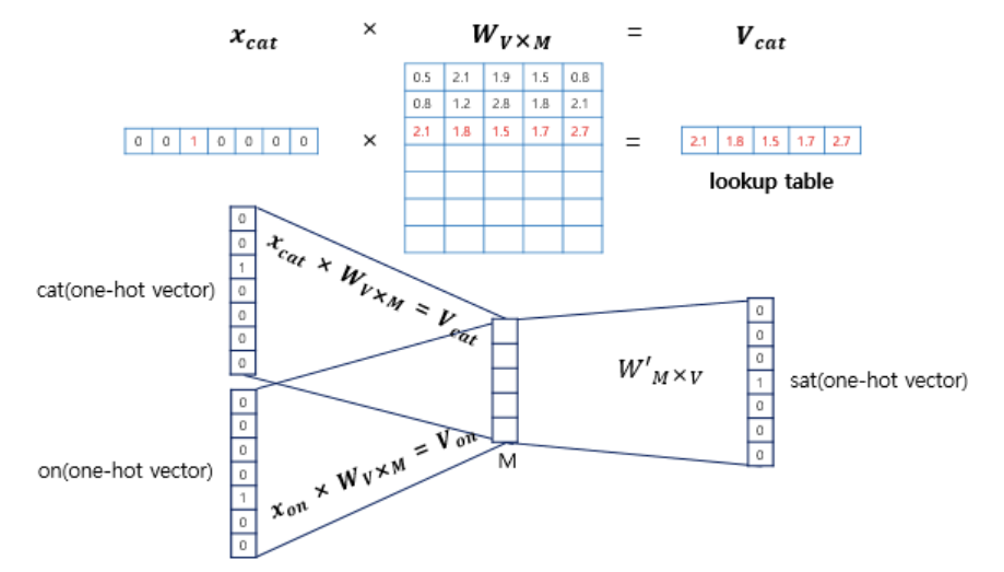

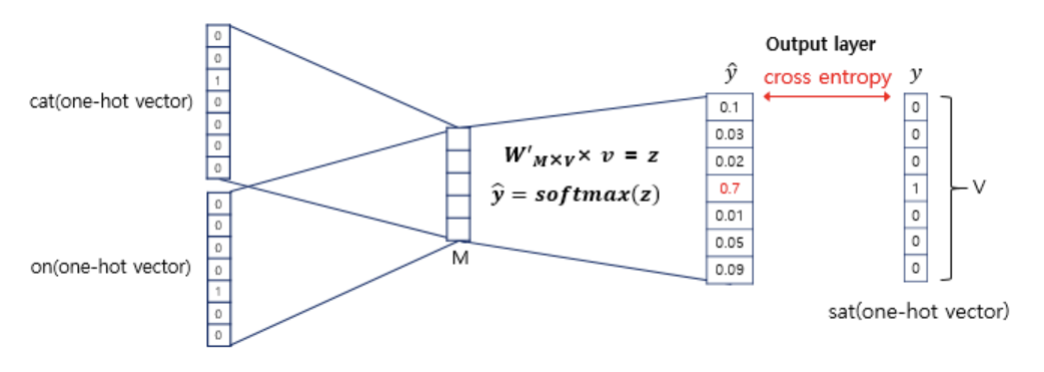

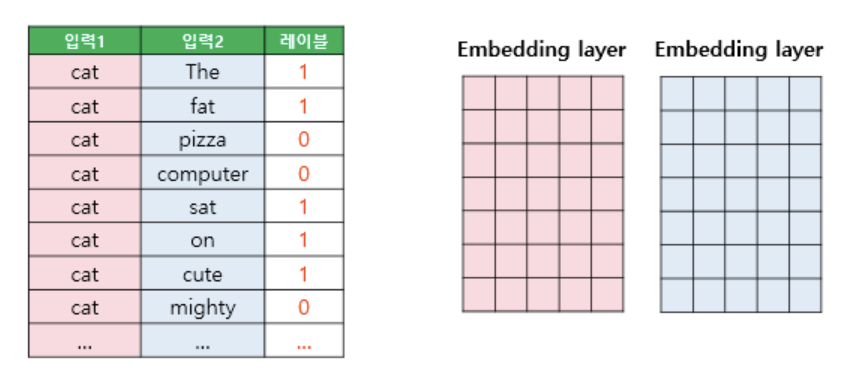

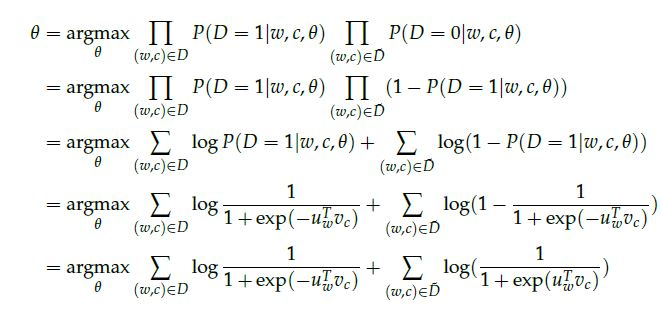

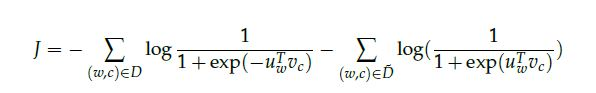

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [52]:
class CBOWNSModel(nn.Module):
    def __init__(self, emb_size, emb_dimension):
        super(CBOWNSModel, self).__init__()
        self.emb_size = emb_size # V: embedding vector size
        self.emb_dimension = emb_dimension # M: table dimension
        self.A_embeddings = nn.Embedding(self.emb_size, self.emb_dimension, sparse=True) # A matrix
        self.B_embeddings = nn.Embedding(self.emb_size, self.emb_dimension, sparse=True)  # B matrix
        self._init_embedding()  # initialization with random

    def _init_embedding(self):
        int_range = 0.5 / self.emb_dimension
        self.A_embeddings.weight.data.uniform_(-int_range, int_range)
        self.B_embeddings.weight.data.uniform_(-int_range, int_range)

    def forward(self, windows, pos_v, neg_v):
        A = []
        for x in windows: # flexible window size
            v = self.A_embeddings(torch.LongTensor(x))  # xw = v (embedding)
            # (5,10), (4,10)
            v = v.data.numpy()
            # (5,10), (4,10)
            v = np.sum(v, axis=0) # summation
            # (10,)
            v = v.tolist()  # save as list form
            A.append(v)  # append to A
        # A: (2, 10) # [ mini_batch_size * emb_dimension(M) ]
        A = torch.FloatTensor(A)  # [ mini_batch_size * emb_dimension(M) ]
        pos_v_emb = self.B_embeddings(torch.LongTensor(pos_v))  # [ mini_batch_size * emb_dimension(M) ]
        # pos_v_emb: (2, 10)
        neg_v_emb = self.B_embeddings(torch.LongTensor(neg_v))  # [ negative_sampling_number * mini_batch_size * emb_dimension ]
        # neg_v_emb: (2, 2, 10)
        
        # Positive Similarity
        score = torch.mul(A, pos_v_emb)
        # score: (2, 10): inner product similarity
        score = torch.sum(score, dim=1)  # summation
        # score: (2,) : score for each v
        score = F.logsigmoid(score)  # make probability by using sigmoid
        
        # Negative Similarity
        # A: (2, 10), neg_v_emb: (2, 2, 10)
        # unsqueeze 2: (2, 10, 1)
        neg_score = torch.bmm(neg_v_emb, A.unsqueeze(2)).squeeze() # (2, 2, 1) -> (2, 2)
        neg_score = torch.sum(neg_score, dim=1)  # summation (2,)
        neg_score = F.logsigmoid((-1) * neg_score)
        # score for each v
        
        # Total loss for batch
        loss = torch.sum(score) + torch.sum(neg_score)
        return -1 * loss

    def save_embedding(self, id2word_dict, file_name):
        embedding = self.A_embeddings.weight.data.numpy()
        file_output = open(file_name, 'w')
        file_output.write('%d %d\n' % (self.emb_size, self.emb_dimension))
        for id, word in id2word_dict.items():
            e = embedding[id]
            e = ' '.join(map(lambda x: str(x), e))
            file_output.write('%s %s\n' % (word, e))


def test():
    model = CBOWNSModel(100, 10)
    id2word = dict()
    for i in range(100):
        id2word[i] = str(i)
    # Batch Size = 2
    windows = [[1, 2, 3, 4, 5], [0, 1, 2, 3]] # windows
    pos_v = [0, 1] # pos_v
    neg_v = [[23, 42], [32, 24]] # neg_v (sampled)
    model.forward(windows, pos_v, neg_v)
    model.save_embedding(id2word, 'test.txt')


if __name__ == '__main__':
    test()